In [1]:
import timeit
import datetime as dt
import os
import subprocess 

import pandas as pd
import numpy as np

#for portofolio optimization 
import scipy.optimize as sco


#visualization
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
%matplotlib inline
#visualization with seaborn
import seaborn as sns
#visualization with plotly 
import plotly.graph_objects as go #for candle chart visualization
import plotly.express as px #for html output


#to get financial data
from pandas_datareader import data as pdr


#for webscraping 
import requests
from bs4 import BeautifulSoup 
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import requests


#for pdf report generation
from reportlab.pdfgen import canvas
from reportlab.platypus import *
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus.tableofcontents import TableOfContents


/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
days_to_lookback = int (input('days to search financial data:'))

days to search financial data:100


In [3]:
date_end = dt.datetime.now() #.today()
date_start = date_end - dt.timedelta(days_to_lookback)

# Create timestamped folder to save reports created later

In [4]:
#timestamp = str(dt.datetime.now()) <- '2020-06-26 20:26:08.775766'  
timestamp =  dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
timestamp

'2020-07-03 11-31-36'

In [5]:
path = os.getcwd() 
reportDir = os.path.join(path,timestamp)
reportDir

'/Users/reejungkim/Documents/Git/reporting automation/2020-07-03 11-31-36'

In [6]:
#create named folder
os.makedirs(reportDir, exist_ok = False)

In [7]:
os.chdir(reportDir)

# Web scraping S&P100 companies from Wikipedia table

In [8]:
website_url = requests.get("https://en.wikipedia.org/wiki/S%26P_100").text

soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())

In [9]:
wiki_table = soup.find('table',{'class':'wikitable sortable'})

In [10]:
data = []
tHeader = []
SP100_tickers = pd.DataFrame()

for tr in wiki_table.find_all("tr"):
    for th in tr.find_all("th")[:1]:
        tHeader = th.get_text(strip=True)
        SP100_tickers[tHeader] = []
    for td in tr.find_all("td")[:1]:
        data.append( td.get_text(strip=True))
        
SP100_tickers[tHeader] = data

In [11]:
SP100_tickers

,Symbol
0,AAPL
1,ABBV
2,ABT
3,ACN
4,ADBE
...,...
96,VZ
97,WBA
98,WFC
99,WMT


# Use DataReader to get financial data of S&P100 companies from yahoo

In [12]:
%%time

df = pd.DataFrame()

for i in data:
    symbol = SP100_tickers.loc[SP100_tickers['Symbol']==i]
    try:
        symbol_data = pdr.DataReader(i, 'yahoo', date_start, date_end).reset_index()
        #display(symbol_data)  
    except (KeyError, ValueError):  # the error could possibly occur when there's "." in stock name 
        symbol_data = pdr.DataReader(i.replace('.','-'), 'yahoo', date_start, date_end).reset_index()
        #symbol_data = pd.DataFrame()
        pass
    except:
        print(i + " - Error.")
        symbol_data = pd.DataFrame()
        pass
    single_table = pd.concat([symbol, symbol_data], axis=0, ignore_index=True) #axis=0 <- row. add frames by row and use fill down.
    single_table['Symbol'].ffill(inplace=True)
    df = df.append(single_table)
    

CPU times: user 7.91 s, sys: 746 ms, total: 8.66 s
Wall time: 1min 8s


In [13]:
df = df.loc[df['Date'].notnull()]

In [14]:
df = df.reset_index(drop=True)

df.groupby(['Symbol']).describe().transpose()

In [15]:
df_Flat = df

In [17]:
d = df.pivot_table(values='Close', index='Date', columns='Symbol', aggfunc=np.sum, margins=False)
d


Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-25,245.520004,67.910004,70.750000,151.820007,305.910004,25.719999,83.000000,193.139999,199.259995,1885.839966,...,234.490005,132.910004,94.500000,32.029999,161.779999,49.939999,41.439999,28.969999,109.400002,37.290001
2020-03-26,258.440002,73.830002,75.809998,171.339996,322.670013,27.510000,89.500000,198.490005,222.199997,1955.489990,...,255.389999,142.490005,99.779999,36.180000,168.880005,53.540001,45.669998,30.900000,109.820000,38.820000
2020-03-27,247.740005,72.669998,74.559998,162.880005,305.829987,25.510000,88.459999,198.270004,218.479996,1900.099976,...,242.449997,139.050003,97.519997,35.770000,161.559998,52.770000,44.000000,30.280001,109.580002,36.950001
2020-03-30,254.809998,75.239998,79.339996,169.820007,318.390015,25.709999,94.639999,208.479996,230.580002,1963.949951,...,251.279999,140.199997,97.839996,35.869999,165.570007,54.770000,45.160000,29.920000,115.190002,37.500000
2020-03-31,254.289993,76.190002,78.910004,163.259995,318.239990,24.250000,91.730003,202.729996,217.750000,1949.719971,...,249.380005,141.039993,93.419998,34.450001,161.119995,53.730000,45.750000,28.700001,113.620003,37.970001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,353.630005,96.129997,88.709999,212.470001,426.920013,29.709999,94.580002,232.839996,246.479996,2692.870117,...,286.880005,162.639999,107.320000,36.060001,189.270004,53.160000,41.169998,25.340000,118.320000,43.619999
2020-06-29,361.779999,96.440002,89.010002,212.720001,424.200012,30.680000,95.440002,231.559998,253.800003,2680.379883,...,289.760010,165.509995,109.480003,36.349998,191.380005,54.689999,42.320000,25.700001,119.059998,44.320000
2020-06-30,364.799988,98.180000,91.430000,214.720001,435.309998,31.180000,96.989998,235.860001,258.540009,2758.820068,...,294.950012,169.070007,111.180000,36.820000,193.169998,55.130001,42.389999,25.600000,119.779999,44.720001


In [170]:
logChange = np.log(d / d.shift(1)) # geometric brownian motion. - make the errors being normally distributed.
# more standardly used than pct_change.  df_temp['Close'] in this case.
logChange

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-26,0.051285,0.083582,0.069078,0.120954,0.053339,0.067281,0.075398,0.027323,0.108967,0.036267,...,0.085379,0.069600,0.054368,0.121834,0.042951,0.069607,0.097195,0.064495,0.003832,0.040210
2020-03-27,-0.042284,-0.015837,-0.016626,-0.050636,-0.053601,-0.075479,-0.011688,-0.001109,-0.016883,-0.028734,...,-0.051996,-0.024438,-0.022910,-0.011397,-0.044312,-0.014486,-0.037252,-0.020269,-0.002188,-0.049370
2020-03-30,0.028138,0.034754,0.062138,0.041725,0.040248,0.007809,0.067530,0.050213,0.053903,0.033051,...,0.035772,0.008236,0.003276,0.002792,0.024518,0.037200,0.026022,-0.011960,0.049928,0.014775
2020-03-31,-0.002043,0.012547,-0.005434,-0.039395,-0.000471,-0.058463,-0.031231,-0.027968,-0.057250,-0.007272,...,-0.007590,0.005974,-0.046228,-0.040392,-0.027245,-0.019171,0.012980,-0.041630,-0.013723,0.012455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,-0.031208,-0.008906,-0.010206,-0.022570,-0.023222,-0.050856,-0.013130,-0.009702,-0.031470,-0.022657,...,-0.032038,-0.026574,-0.029381,-0.053717,-0.024580,-0.020850,-0.020912,-0.077063,-0.011679,-0.034917
2020-06-29,0.022785,0.003220,0.003376,0.001176,-0.006392,0.032127,0.009052,-0.005512,0.029266,-0.004649,...,0.009989,0.017492,0.019927,0.008010,0.011086,0.028375,0.027550,0.014107,0.006235,0.015920
2020-06-30,0.008313,0.017881,0.026825,0.009358,0.025853,0.016166,0.016110,0.018399,0.018504,0.028845,...,0.017753,0.021281,0.015409,0.012847,0.009310,0.008013,0.001653,-0.003899,0.006029,0.008985


In [171]:
tickers_bestPerformed = logChange.describe().transpose().sort_values(by='mean', ascending=False).head(5)
symbols = tickers_bestPerformed.index.tolist()

In [173]:
logChange = logChange[symbols]
logChange

Symbol,PYPL,LOW,DD,NVDA,AMZN
Date,,,,,
2020-03-25,NaN,NaN,NaN,NaN,NaN
2020-03-26,0.050128,0.051108,0.078676,0.046224,0.036267
2020-03-27,-0.073703,-0.012908,-0.060781,-0.017688,-0.028734
2020-03-30,0.037273,0.019694,-0.006227,0.049632,0.033051
2020-03-31,-0.013384,-0.030444,0.014176,-0.007521,-0.007272
...,...,...,...,...,...
2020-06-26,-0.009494,-0.018072,-0.031961,-0.035938,-0.022657
2020-06-29,-0.014858,0.031266,0.020214,0.004903,-0.004649
2020-06-30,0.034331,0.011912,0.012500,0.031851,0.028845


In [174]:
logChange.mean()*252 #252 business days per year in general

Symbol
PYPL    2.249786
LOW     1.764155
DD      1.754257
NVDA    1.636657
AMZN    1.559431
dtype: float64

In [175]:
logChange.cov()*252

Symbol,PYPL,LOW,DD,NVDA,AMZN
Symbol,,,,,
PYPL,0.257393,0.118646,0.120828,0.177731,0.094196
LOW,0.118646,0.155679,0.137429,0.120294,0.039980
DD,0.120828,0.137429,0.297132,0.107507,0.039318
NVDA,0.177731,0.120294,0.107507,0.256939,0.112658
AMZN,0.094196,0.039980,0.039318,0.112658,0.121820


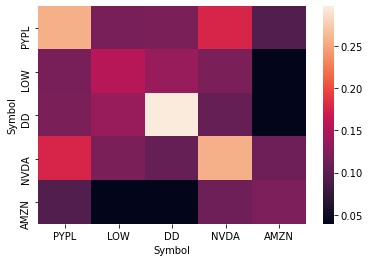

In [176]:
sns.heatmap(logChange.cov()*252)

In [187]:
np.random.seed(0)
weights = np.random.random(len(symbols))
weights /= np.sum(weights)
weights

array([0.19356424, 0.25224431, 0.21259213, 0.19217803, 0.14942128])

#### Expected return:
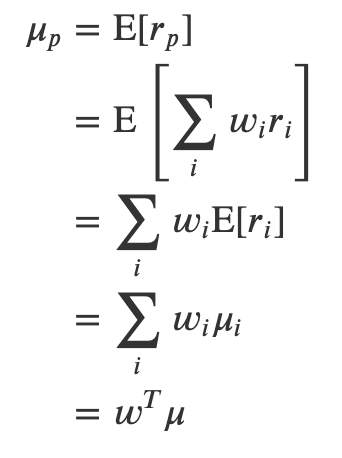

In [188]:
#return of portfolio
np.sum(logChange.mean()*weights)*252

1.8009589211824246

In [189]:
#variance of portfolio
np.dot(weights.T, np.dot(logChange.cov() * 252, weights))

0.13255728699833244

In [190]:
#standard deviation of portfolio (volatility)
np.sqrt(np.dot(weights.T, np.dot(logChange.cov() * 252, weights)))

0.36408417570437257

## simulation

In [192]:
prets = []  #stores list of returns
pvols = []  #stores list of volatilities

for p in range (2000):
    weights = np.random.random(len(symbols))
    weights /= np.sum(weights)
    prets.append(np.sum(logChange.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(logChange.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

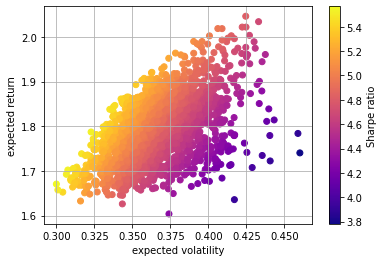

In [193]:

plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='plasma')

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio') #beta
plt.show()

In [194]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        포트폴리오 내의 증권 비중
    
    Returns
    =======
    pret : float
        포트폴리오 수익률의 기댓값
    pvol : float
        포트폴리오 변동성의 기댓값
    pret / pvol : float
        무위험 이자율이 0일 때의 포트폴리오 샤프 지수
    '''
    weights = np.array(weights)
    pret = np.sum(logChange.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(logChange.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

## Sharp ratio optimization

In [195]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [197]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
cons
w = len(symbols)*[1. /len(symbols),]
statistics(w)

array([1.79285699, 0.35922903, 4.99084667])

In [199]:
bnds = tuple((0, 1) for x in range(len(symbols)))
bnds

((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

In [200]:
#set initial point
len(symbols)* [1./len(symbols),]

[0.2, 0.2, 0.2, 0.2, 0.2]

#### Minimize a scalar function of one or more variables using Sequential Least Squares Programming (SLSQP).

#### scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

In [201]:
%%time

opts = sco.minimize(min_func_sharpe, len(symbols)* [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)


CPU times: user 60.5 ms, sys: 2.36 ms, total: 62.9 ms
Wall time: 61.3 ms


In [202]:
opts

     fun: -5.624099400235101
     jac: array([ 5.20944595e-04, -4.31954861e-04,  4.11868095e-05,  2.01310503e+00,
        2.17437744e-04])
 message: 'Optimization terminated successfully.'
    nfev: 53
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([1.09642717e-01, 3.75139344e-01, 4.00192241e-02, 3.88089396e-15,
       4.75198715e-01])

In [203]:
a=opts['x'].round(3)
np.sum(logChange.mean()*a)*252


1.7199343767093738

In [204]:
statistics(opts['x']).round(3)

array([1.72 , 0.306, 5.624])

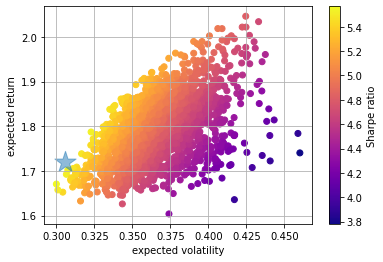

In [205]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='plasma')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5)
plt.show()

In [206]:
statistics(opts['x']).round(3)

array([1.72 , 0.306, 5.624])

#### Volatility Optimization

In [207]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [209]:
optv = sco.minimize(min_func_variance,  len(symbols) * [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [210]:
optv

     fun: 0.08755607169832164
     jac: array([0.20900662, 0.17499237, 0.17465171, 0.23056719, 0.1752238 ])
 message: 'Optimization terminated successfully.'
    nfev: 56
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.        , 0.37359503, 0.04403869, 0.        , 0.58236628])

In [211]:
statistics(optv['x']).round(3)

array([1.644, 0.296, 5.558])

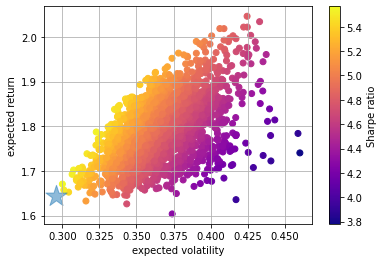

In [212]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='plasma')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_optv = statistics(optv['x']).round(3)
plt.scatter(pt_optv[1], pt_optv[0], marker="*", s=500, alpha=0.5)
plt.show()

### Efficient Frontier

In [213]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [214]:
def min_func_port(weights):
    return statistics(weights)[1]

In [231]:
prets.min(), prets.max()

(1.603789180534093, 2.0461710019794483)

In [232]:
%%time
trets = np.linspace(prets.min(), prets.max(), 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, len(symbols)* [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 4.7 s, sys: 19 ms, total: 4.72 s
Wall time: 4.73 s


In [233]:
tvols

array([0.30886893, 0.30383355, 0.29999423, 0.2973973 , 0.29607545,
       0.29604577, 0.29693928, 0.29795645, 0.29906952, 0.3002774 ,
       0.30157897, 0.30297305, 0.30445837, 0.30603358, 0.30769732,
       0.30944816, 0.31128462, 0.31320521, 0.31520838, 0.31729258,
       0.31945621, 0.32169768, 0.32401538, 0.32640767, 0.32887294,
       0.33140956, 0.33401589, 0.33669031, 0.33943119, 0.34223694,
       0.34510598, 0.34803677, 0.35102775, 0.35407739, 0.35718421,
       0.36034672, 0.36356346, 0.36683294, 0.37015372, 0.37352453,
       0.37694423, 0.38041123, 0.38392443, 0.38748248, 0.39108416,
       0.39472829, 0.39841307, 0.40213845, 0.40590285, 0.4097052 ])

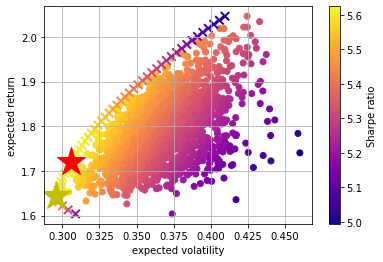

In [234]:
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o', cmap='plasma')
            # 무작위 포트폴리오
    
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x', s=70, linewidth=2, cmap='plasma')
            # Efficient frontier
    
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=30)
            # Optimal Sharp ratio
    
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=30)
            # Optimal volatility
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

### Capital Market Line
Capital Asset Pricing Model, CAPM)

In [235]:
import scipy.interpolate as sci

In [236]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [237]:
tck = sci.splrep(evols, erets)

In [238]:
def f(x):
    ''' 효율적 투자선 함수 (스플라인 근사) '''
    return sci.splev(x, tck, der=0)

def df(x):
    ''' 효율적 투자선 함수의 1차 도함수 '''
    return sci.splev(x, tck, der=1)

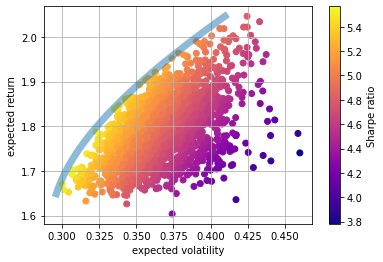

In [239]:
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o', cmap='plasma')
            # 무작위 포트폴리오

plt.plot(evols, f(evols), lw=7, alpha=0.5)    

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [240]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [241]:
opt = sco.fsolve(equations, [0.01, 1.0, 0.1])
opt

array([0.01      , 5.59140137, 0.30594074])

In [242]:
np.round(equations(opt), 6)

array([ 0., -0.,  0.])

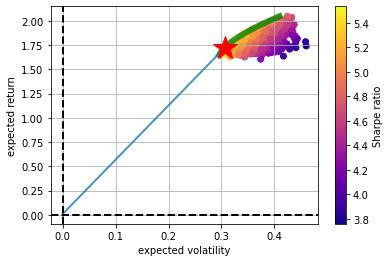

In [243]:
plt.scatter(pvols, prets,
            c=(prets - 0.01) / pvols, marker='o', cmap='plasma')
            # 무작위 포트폴리오
plt.plot(evols, erets, 'g', lw=6, alpha=0.8)
            # 효율적 투자선
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=2, alpha=0.8)
            # 자본 시장선
plt.plot(opt[2], f(opt[2]), 'r*', markersize=25.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [245]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(min_func_port, len(symbols) * [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)
res['x'].round(3)

array([0.111, 0.375, 0.039, 0.   , 0.474])

# Analytics

###  main data frames to be used: 
#### 1. df_Flat
#### 2. df  
#### 3. df_Flat_pct_change

In [ ]:
df_Flat

In [ ]:
df = df.groupby(['Symbol', 'Date']).sum()

df

In [ ]:
df_Flat.groupby('Symbol')['Close'].pct_change()

In [ ]:
df_Flat_pct_change = pd.DataFrame()

for i in df_Flat.columns.tolist():
    if i !="Symbol" and i!="Date" :
        data = df_Flat.groupby('Symbol')[i].pct_change()
        df_Flat_pct_change[i] = data

df_Flat_pct_change['Symbol'] = df_Flat['Symbol']
df_Flat_pct_change['Date'] = df_Flat['Date']

df_Flat_pct_change
cols = df_Flat.columns.tolist()
df_Flat_pct_change = df_Flat_pct_change[cols]

df_Flat_pct_change

In [ ]:
df_temp = df.unstack(level=0).pct_change()  #df.groupby(['Symbol', 'Date']).sum().pct_change()

df_temp

## Functions defined

In [ ]:
def format_column_number(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col]= pd.Series([round(val, 2 ) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
            pass
    return dataframe

def format_column_percentage(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col] = pd.Series(["{0:.2f}%".format(val*100) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
        
    return dataframe

In [ ]:
def CreatePctPlotAndSavefig(listTickers, stringTitle, stringYlabel, jpg_name):
    sns.relplot(x='Date', y='Close', kind='line', hue ='Symbol',data=df_Flat_pct_change.groupby(['Symbol', 'Date']).sum().loc[listTickers].reset_index()).fig.autofmt_xdate()
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    plt.title(stringTitle, fontsize=16)
    plt.ylabel(stringYlabel, fontsize=14)
    plt.xlabel('Date', fontsize=14)
    #plt.tight_layout()

    jpg_name = jpg_name + '.jpg'
    plt.savefig(jpg_name, bbox_inches='tight')

def CreatePlotAndSavefig(listTickers, stringTitle, stringYlabel, jpg_name):
    sns.relplot(x='Date', y='Close', kind='line', hue ='Symbol',data=df.loc[listTickers].reset_index()).fig.autofmt_xdate()
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    plt.title(stringTitle, fontsize=16)
    plt.ylabel(stringYlabel, fontsize=14)
    plt.xlabel('Date', fontsize=14)

    jpg_name = jpg_name + '.jpg'
    plt.savefig(jpg_name, bbox_inches='tight')

### Best performed tickers based on percentage of of growth

In [ ]:
tickers_bestPerformed = df_temp['Close'].describe().transpose().sort_values(by='mean', ascending=False).head(5) #df_pct_change['Close'].describe().transpose().sort_values(by='mean', ascending=False).head(5)



In [ ]:
tickers_bestPerformed

In [ ]:
for i in range(len(tickers_bestPerformed.index)):
    fig = go.Figure(data=[go.Candlestick(x= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['Date'],
                open= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['Open'],
                high= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['High'],
                low= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['Low'],
                close= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    #fig.show()
    fig_name = 'candle chart ' + tickers_bestPerformed.index[i] + '.html'
    fig.write_html(fig_name)
    

In [ ]:
tickers_bestPerformed = format_column_percentage(tickers_bestPerformed, tickers_bestPerformed.columns[1:])
tickers_bestPerformed

In [ ]:
CreatePlotAndSavefig(tickers_bestPerformed.index, 'Best performed companies based on % Changes in Close Price', 'change in closing price ($)', 'highest growth closing price')

In [ ]:
CreatePctPlotAndSavefig(tickers_bestPerformed.index, 'Best performed companies based on % Changes in Close Price', 'change in closing price (%)', 'highest growth closing pct change')

## Volatility

### most volatiled companies. (based on the standard deviation of percentage change)

#### Top 5 companies with highest volatillity rates among S&P 100

In [ ]:
tickers_volatile = df_temp['Close'].describe().transpose().sort_values(by='std', ascending=False).head(5)#.round(2)
tickers_volatile = format_column_percentage(tickers_volatile, tickers_volatile.columns[1:])

In [ ]:
tickers_volatile.index

In [ ]:
CreatePlotAndSavefig(tickers_volatile.index, 'Most volatiled companies based on % Changes in Close Price', 'change in closing price ($)', '2')

In [ ]:
CreatePctPlotAndSavefig(tickers_volatile.index, 'Most volatiled companies based on % Changes in Close Price', 'change in closing price (%)', '1')

## Get date where highest drop and raise of closing price occured. 

In [ ]:
highest_raise = df_Flat_pct_change.groupby(['Symbol'])['Close'].transform(max) == df_Flat_pct_change['Close']
df_Flat_pct_change[highest_raise]

In [ ]:
highest_drop = df_Flat_pct_change.groupby(['Symbol'])['Close'].transform(min) == df_Flat_pct_change['Close']
drops = df_Flat_pct_change[highest_drop]

In [ ]:
drops

In [ ]:
drops['DateStr'] = drops['Date'].apply(lambda x: x.strftime('%Y/%m/%d'))

In [ ]:
drops['search_key'] = drops['Symbol']  + ' ' + drops['DateStr']

## Search and scrap what happened to the stock on the date

In [ ]:
search_list = drops.loc[drops['Symbol'].isin (tickers_bestPerformed.index)]['search_key'].tolist()

In [ ]:
search_list

In [ ]:
driver = webdriver.Chrome('/Users/reejungkim/opt/anaconda3/libexec/chromedriver')  
driver.get('https://news.google.com/topstories?hl=en-GB&tab=wn&gl=GB&ceid=GB:en')
driver.implicitly_wait(3)

In [ ]:
xpath = '//*[@id="gb"]/div[2]/div[2]/div/form/div[1]/div/div/div/div/div[1]/input[2]'
search = driver.find_element_by_xpath(xpath)

In [ ]:
titles = []
links = []
searched=[]

for keyword in search_list:
    driver.implicitly_wait(30)
    search.clear()
    search.send_keys(keyword)
    search.send_keys(Keys.ENTER)
    driver.implicitly_wait(30)

    url = driver.current_url
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, 'lxml')

    for link in soup.select('h3 >a')[:5]:
        href = 'https://news.google.com' + link.get('href')[1:]
        title = link.string
        searched.append(keyword)
        titles.append(title)
        links.append(href)
    
    search.clear()

In [ ]:
news_data = { 'searched keyword': searched, 'title': titles, 'link': links}
news_df = pd.DataFrame(news_data, columns=['searched keyword','title', 'link'])

news_df['link'] = "<a href=" + "\"{" + news_df['link'] + "}" + "\"" + ">Click</a>"

In [ ]:
news_df

In [ ]:
news_df.to_csv('./news.csv')

#Open pdf file generated
subprocess.run(['open', './news.csv'], check=True)

## S&P 100 total

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(x='Date', y='Close', kind='line', data=df_Flat).fig.autofmt_xdate()

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.title('S&P100 Total', fontsize=16)
plt.ylabel('Close', fontsize=14)
plt.xlabel('Date', fontsize=14)

jpg_name = 'SP100_total.jpg'
plt.savefig(jpg_name, bbox_inches='tight')

pd.options.display.float_format = '{:,.2%}'.format
display(tickers_volatile), display(tickers_bestPerformed)

In [ ]:
#pd.options.display.float_format = '{:,.2f}'.format
dataToExport = df.loc[tickers_bestPerformed.index].unstack(0).describe()
dataToExport = dataToExport.transpose().reset_index().groupby(['Symbol', 'level_0']).sum().round(2)

dataToExport.rename_axis(index={"level_0":"Type"}, inplace=True)
dataToExport

In [ ]:
#format_column_percentage(dataToExport, dataToExport.columns[1:])

dataToExport2 = df.loc[tickers_bestPerformed.index].unstack(0).describe().stack(0)
dataToExport2

# Create PDF file

In [ ]:
today = dt.datetime.today().strftime('%Y-%m-%d')
pdf_file_name = "Report "+ today +".pdf"

In [ ]:
def PrepareTableForReportLab(dataframe):
    
    data = dataframe

    'handling grouped first index column'
    a= []
    for i in range(len(data)):
        #print(i, data.index.get_level_values(0)[i])
        if data.index.get_level_values(0)[i-1] == data.index.get_level_values(0)[i]:
            a.append(i)
    a.sort(reverse=True)

    as_list = data.index.get_level_values(0).tolist()
    for i in a:
        as_list[i] = ""

        
    'flat dataframe'
    data = data.reset_index()
    'remove duplicated values from first column which was index before resetting index'
    first_col_name = data.columns[0]
    data[first_col_name] = as_list 
    
    #data = dataframe.reset_index()
    #colwidths = 800/len(data.columns) 
    data = [data.columns.to_list()] + data.values.tolist() 

    #tbl = Table(data) # 
    tbl = Table(data) #, colwidths ) #, rowheights)
    tbl.setStyle(TableStyle([
    ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.black),
    ('BOX', (0, 0), (-1, -1), 0.25, colors.black),
    ('ALIGN', (1,1), (-1,-1), 'RIGHT'),
    ('BACKGROUND', (0,0), (-1,0), colors.Color(0,0.7,0.7))
    ]))
    
    return tbl

def PrepareTableForReportLab_News_df(dataframe):
    
    data = dataframe

    'handling grouped first index column'
    a= []
    for i in range(len(data)):
        #print(i, data.index.get_level_values(0)[i])
        if data.index.get_level_values(0)[i-1] == data.index.get_level_values(0)[i]:
            a.append(i)
    a.sort(reverse=True)

    as_list = data.index.get_level_values(0).tolist()
    for i in a:
        as_list[i] = ""

        
    'flat dataframe'
    data = data.reset_index()
    'remove duplicated values from first column which was index before resetting index'
    first_col_name = data.columns[0]
    data[first_col_name] = as_list 
    
    #data = dataframe.reset_index()
    colwidths = 800/len(data.columns) 
    rowheights = 1.5*inch
    data = [data.columns.to_list()] + data.values.tolist() 

    #tbl = Table(data) # 
    tbl = Table(data , colwidths, rowheights)
    tbl.setStyle(TableStyle([
    ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.black),
    ('BOX', (0, 0), (-1, -1), 0.25, colors.black),
    ('ALIGN', (1,1), (-1,-1), 'RIGHT'),
    ('BACKGROUND', (0,0), (-1,0), colors.Color(0,0.7,0.7))
    ]))
    
    return tbl

In [ ]:
story = []

In [ ]:
story.append(Paragraph("Highest growth rates", getSampleStyleSheet()['Heading1']))
story.append(Paragraph("highest growth rates in past <i>" + str(days_to_lookback) + " days</i>.",  getSampleStyleSheet()['Normal']))
story.append(Spacer(1,20))
story.append((PrepareTableForReportLab(dataToExport)))
story.append(Spacer(1,20))
story.append(PrepareTableForReportLab(tickers_bestPerformed))
story.append(PageBreak())

story.append(Paragraph("Volatility", getSampleStyleSheet()['Heading1']))
story.append(Paragraph("highest volatility rates in past <i>" + str(days_to_lookback)  + " days</i>.",  getSampleStyleSheet()['Normal']))
story.append(Spacer(1,20))
story.append(PrepareTableForReportLab(tickers_volatile))
story.append(PageBreak())

#### Add graph images saved in the timestamped folder

In [ ]:
for file in sorted(os.listdir(reportDir), key=os.path.getmtime):
    if file.endswith('jpg'):
        temp = file
        temp = 'image_'+ temp
        print(temp)
        temp = Image(file)
        #story.append(Spacer(1, 20))
        story.append(temp)

story.append(PageBreak())
story.append(PrepareTableForReportLab_News_df(news_df))

In [ ]:
doc = SimpleDocTemplate(pdf_file_name, pagesize = landscape(letter), topMargin = inch * .25, bottomMargin = inch * .25)
doc.build(story)

In [ ]:
#open folder
subprocess.run(['open', reportDir], check=True)

In [ ]:
#Open pdf file generated
subprocess.run(['open', pdf_file_name], check=True)